In [ ]:
!pip install konlpy

bag_of_words
문서1 : 정부가 발표하는 물가상승률과 소비자가 느끼는 물가상승률은 다르다.
bow를 만들어 vocaburary를 만들어 각 단어에 정수 인덱스 할당하

In [ ]:
from konlpy.tag import Okt

okt = Okt()

def build_bag_of_words(document):
  # 온점 제거 및 형태소 분석
  document = document.replace('.', '')
  tokenized_document = okt.morphs(document)

  word_to_index = {}
  bow = []

  for word in tokenized_document:  
    if word not in word_to_index.keys():
          word_to_index[word] = len(word_to_index)  
          # BoW에 전부 기본값 1을 넣는다.
          bow.insert(len(word_to_index) - 1, 1)
    else:
          # 재등장하는 단어의 인덱스
          index = word_to_index.get(word)
          # 재등장한 단어는 해당하는 인덱스의 위치에 1을 더한다.
          bow[index] = bow[index] + 1

  return word_to_index, bow

문서1 입력

In [ ]:
doc1 = "정부가 발표하는 물가상승률과 소비자가 느끼는 물가상승률은 다르다."
vocab, bow = build_bag_of_words(doc1)
print('vocabulary :', vocab)
print('bag of words vector :', bow)

문서2: 소비자는 주로 소비하는 상품을 기준으로 물가상승률을 느낀다 입력

In [ ]:
doc2 = '소비자는 주로 소비하는 상품을 기준으로 물가상승률을 느낀다.'

vocab, bow = build_bag_of_words(doc2)
print('vocabulary :', vocab)
print('bag of words vector :', bow)

문서3: 정부가 발표하는 물가상승률과 소비자가 느끼는 물가상승률은 다르다. 소비자는 주로 소비하는 상품을 기준으로 물가상승률을 느낀다 입력

In [ ]:
doc3 = doc1 + ' ' + doc2
vocab, bow = build_bag_of_words(doc3)
print('vocabulary :', vocab)
print('bag of words vector :', bow)

In [34]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Mecab
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter

In [35]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x78a417d14760>)

In [37]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [38]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

훈련용 리뷰 개수 : 150000


In [39]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [40]:
print('테스트용 리뷰 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력

테스트용 리뷰 개수 : 50000


In [41]:
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [42]:
# document 열과 label 열의 중복을 제외한 값의 개수
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [45]:
# document 열의 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)

In [46]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


<Axes: xlabel='label'>

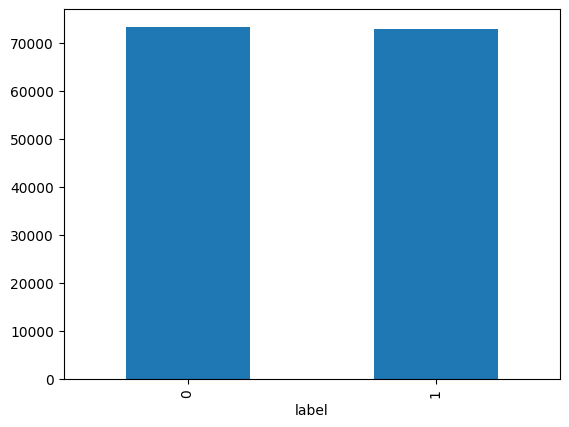

In [47]:
train_data['label'].value_counts().plot(kind = 'bar')

In [48]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  73342
1      1  72841


In [49]:
print(train_data.isnull().values.any())

True


In [50]:
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


In [51]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


In [52]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [53]:
print(len(train_data))

146182


In [54]:
#알파벳과 공백을 제외하고 모두 제거
eng_text = 'do!!! you expect... people~ to~ read~ the FAQ, etc. and actually accept hard~! atheism?@@'
print(re.sub(r'[^a-zA-Z ]', '', eng_text))

do you expect people to read the FAQ etc and actually accept hard atheism


In [55]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [56]:
train_data['document'] = train_data['document'].str.replace('^ +', "", regex=True) # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


/tmp/ipykernel_30/3966077745.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['document'].replace('', np.nan, inplace=True)


In [57]:
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


In [58]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145393


전처리단계

In [59]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True) # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "", regex=True) # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


/tmp/ipykernel_30/2256962620.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
